In [1]:
import pandas as pd

In [2]:
import tensorflow.keras as keras
import numpy as np

In [3]:
df = pd.read_csv("dataset/S01R01.txt", sep=" ", header=0, names=["Time", "AHF", "AV", "AHL", "UHF", "UV", "UHL", "THF", "TV", "THL", "Annotation"])
df = df[df.Annotation != 0]
df.Annotation -= 1

In [4]:
df.head()

,Time,AHF,AV,AHL,UHF,UV,UHL,THF,TV,THL,Annotation
47998,750000,-30,990,326,-45,972,181,-38,1000,29,0
47999,750015,-30,1000,356,-18,981,212,-48,1028,29,0
48000,750031,-20,990,336,18,981,222,-38,1038,9,0
48001,750046,-20,1000,316,36,990,222,-19,1038,9,0
48002,750062,0,990,316,36,990,212,-29,1038,29,0


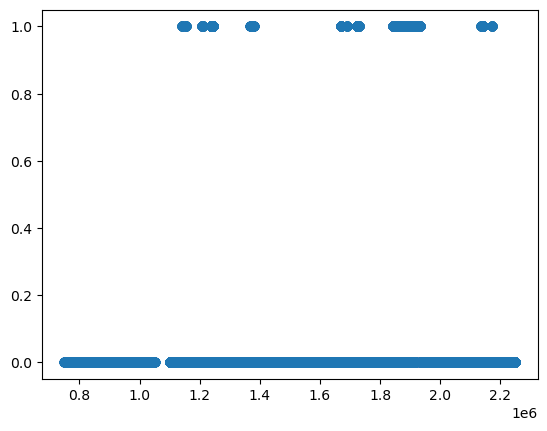

In [5]:
import matplotlib.pyplot as plt

plt.scatter(df['Time'], df['Annotation'])
plt.show()

In [6]:
#use multiple files to train & test
def createData(df, time_steps, x, y):
    n = df.shape[0]
    df = df.iloc(0)
    i = 0
    while i < n-1:
        a = []
        b = []
        for j in range(time_steps):
            if i >= n-1:
                break
            a.append(list(df[i]['AHF':'THL']))
            b.append(df[i]['Annotation'])
            i += 1

        if (len(a) != time_steps):
            break
        x.append(a)
        y.append(b)

    return x, y


def multiDataFrame(text_files, time_steps):
    x = []
    y = []
    for files in text_files:
        df = pd.read_csv("dataset/" + files, sep=" ", header=0, names=["Time", "AHF", "AV", "AHL", "UHF", "UV", "UHL", "THF", "TV", "THL", "Annotation"])
        df = df[df.Annotation != 0]
        df.Annotation -= 1
        x, y = createData(df, time_steps, x, y)
        
    return np.array(x), np.array(y)



In [7]:
#figuring out the longest & the shortest chain 
chains = [[], []]
cur = 1
for i in range(1, df.shape[0]):
    this = df.iloc(0)[i]['Annotation']
    prev = df.iloc(0)[i-1]['Annotation']
    if (this == prev):
        cur += 1; 
    else:
        chains[prev].append(cur)
        cur = 1

print(np.average(chains[0]), np.average(chains[1]))

4595.055555555556 285.94444444444446


In [8]:
X, y = multiDataFrame(['S01R01.txt', 'S01R02.txt', 'S02R01.txt', 'S02R02.txt', 'S03R01.txt', 'S03R02.txt', 'S03R03.txt', 'S04R01.txt', 'S05R01.txt', 'S05R02.txt', 'S06R01.txt', 'S06R02.txt'], 100) #~1.5s worth of data

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

val_n = 300

X_val = X_train[-val_n:]
y_val = y_train[-val_n:]
X_train = X_train[:-val_n]
y_train = y_train[:-val_n]


In [10]:
y_train.shape, X_train.shape


((4838, 100), (4838, 100, 9))

In [11]:
model = keras.Sequential()

model.add(keras.layers.LSTM(7, input_shape=X_train.shape[1:], return_sequences=True))
# model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(5, activation="relu"))

model.add(keras.layers.Dense(5, activation="relu"))
model.add(keras.layers.Dropout(0.1))


model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

2022-12-16 20:02:29.911163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 7)            476       
                                                                 
 dense (Dense)               (None, 100, 5)            40        
                                                                 
 dense_1 (Dense)             (None, 100, 5)            30        
                                                                 
 dropout (Dropout)           (None, 100, 5)            0         
                                                                 
 dense_2 (Dense)             (None, 100, 1)            6         
                                                                 
Total params: 552
Trainable params: 552
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['acc', f1_m, precision_m, recall_m])

In [23]:
history = model.fit(X_train, y_train, batch_size=20, epochs=2, validation_data=(X_val, y_val))

Epoch 1/2
242/242 [==============================] - 6s 20ms/step - loss: 0.2906 - acc: 0.8935 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2326 - val_acc: 0.9278 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/2
242/242 [==============================] - 5s 19ms/step - loss: 0.2813 - acc: 0.8935 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2220 - val_acc: 0.9278 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00


In [26]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

In [27]:
print(loss, accuracy, f1_score, precision, recall)

0.2664440870285034 0.901244580745697 0.0 0.0 0.0


In [28]:
y_pred = model.predict(X_test)

69/69 [==============================] - 1s 4ms/step


In [29]:
y_pred

array([[[0.14939512],
        [0.12262007],
        [0.11905599],
        ...,
        [0.06132647],
        [0.06132647],
        [0.06664049]],

       [[0.01866139],
        [0.01450282],
        [0.01395186],
        ...,
        [0.01386597],
        [0.01386597],
        [0.01386597]],

       [[0.01271831],
        [0.01271831],
        [0.01271831],
        ...,
        [0.01271831],
        [0.01271831],
        [0.01271831]],

       ...,

       [[0.14939512],
        [0.12262007],
        [0.11905599],
        ...,
        [0.06166242],
        [0.06137196],
        [0.0669485 ]],

       [[0.2224881 ],
        [0.21172133],
        [0.10674692],
        ...,
        [0.07001057],
        [0.07001057],
        [0.07001057]],

       [[0.09043312],
        [0.06381812],
        [0.07028438],
        ...,
        [0.06166242],
        [0.06137091],
        [0.06133162]]], dtype=float32)

In [32]:
y_pred = np.round(y_pred)
np.count_nonzero(y_pred)
#essentially, all the guesses were 0

0

In [38]:
def createModel(X_train, y_train, X_test, y_test, X_val, y_val, optimizer, loss, metrics, batch_size=20, epochs=25):
    model = keras.Sequential()

    model.add(keras.layers.LSTM(7, input_shape=X_train.shape[1:], return_sequences=True))
    # model.add(keras.layers.Dropout(0.1))

    model.add(keras.layers.Dense(5, activation="relu"))

    model.add(keras.layers.Dense(5, activation="relu"))
    model.add(keras.layers.Dropout(0.1))


    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.summary()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    history = model.fit(X_train, y_train, batch_size=20, epochs=2, validation_data=(X_val, y_val))
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=2)

[1.]
